In [112]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
from haversine import haversine, Unit
import numpy as np

In [79]:
pd.set_option("display.max_rows", 1000)

In [ ]:
# read in data and examine 

In [2]:
requests = pd.read_csv('requests.csv', parse_dates=True)

In [3]:
paths = pd.read_csv('vehicle_paths.csv', parse_dates=True)

In [4]:
events = pd.read_csv('vehicle_events.csv')

In [5]:
requests.head()

,Timestamp,Requested_Pickup,Requested_Dropoff,Actual_Pickup,Actual_Dropoff
0,1380949200,1149,725,218,3601
1,1380949200,1225,1714,2003,3601
2,1380949200,1237,3143,1314,2218
3,1380949200,1323,3566,1330,2573
4,1380949200,1328,2466,1323,2473


In [6]:
events.head()

,Timestamp,Vehicle_ID,Stop_Intersection,Stop_Passengers,Requested_Stop_Intersection
0,1380949200,83,2767,0,2764
1,1380949200,89,3070,0,1818
2,1380949200,112,97,0,972
3,1380949200,121,215,0,396
4,1380949200,141,1314,0,1237


In [7]:
events['Stop_Passengers'].unique()

array([ 0,  1, -1])

In [8]:
paths.head()

,Timestamp,Vehicle_ID,Latitude,Longitude,Num_Passengers
0,1380949200,83,40.73062,-73.99065,0
1,1380949200,89,40.71429,-74.01153,0
2,1380949200,112,40.77178,-73.97919,0
3,1380949200,121,40.73974,-74.00249,0
4,1380949200,141,40.77114,-73.96392,0


In [9]:
paths['Num_Passengers'].unique()

array([0, 1, 2, 3, 4])

In [10]:
# create one df that can answer questions 7 and 8
merged_df = pd.merge(paths, events, how='outer', on=['Timestamp', 'Vehicle_ID'])

In [11]:
merged_df.shape

(2898718, 8)

In [16]:
# checking how unique the "primary keys are"
(paths['Timestamp'].astype(str) + '_' + paths['Vehicle_ID'].astype(str)).value_counts().value_counts()

1    2637434
2       2937
3         41
dtype: int64

In [17]:
paths.shape

(2643431, 5)

In [ ]:
# update timestamp to be readable

In [18]:
merged_df['Timestamp'] = pd.to_datetime(merged_df['Timestamp'], unit='s')

In [19]:
# check that vehicle id is never null
merged_df[merged_df['Vehicle_ID'].isna()]

,Timestamp,Vehicle_ID,Latitude,Longitude,Num_Passengers,Stop_Intersection,Stop_Passengers,Requested_Stop_Intersection


In [20]:
merged_df.head()

,Timestamp,Vehicle_ID,Latitude,Longitude,Num_Passengers,Stop_Intersection,Stop_Passengers,Requested_Stop_Intersection
0,2013-10-05 05:00:00,83,40.73062,-73.99065,0.0,2767.0,0.0,2764.0
1,2013-10-05 05:00:00,89,40.71429,-74.01153,0.0,3070.0,0.0,1818.0
2,2013-10-05 05:00:00,112,40.77178,-73.97919,0.0,97.0,0.0,972.0
3,2013-10-05 05:00:00,121,40.73974,-74.00249,0.0,215.0,0.0,396.0
4,2013-10-05 05:00:00,141,40.77114,-73.96392,0.0,1314.0,0.0,1237.0


In [ ]:
# graph some initial findings by hour

In [21]:
merged_df['hour'] = [x.hour for x in merged_df['Timestamp']]

In [42]:
merged_df['hour_trunc'] = [x.replace(minute=0, second=0, microsecond=0) for x in merged_df['Timestamp']]

In [43]:
hourly_pickups = merged_df[merged_df['Stop_Passengers'] == 1].groupby('hour_trunc')['Vehicle_ID'].count()

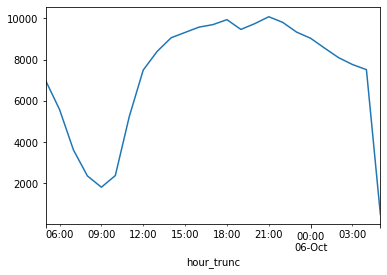

In [44]:
hourly_pickups.plot()

In [45]:
hourly_dropoffs = merged_df[merged_df['Stop_Passengers'] == -1].groupby('hour_trunc')['Vehicle_ID'].count()

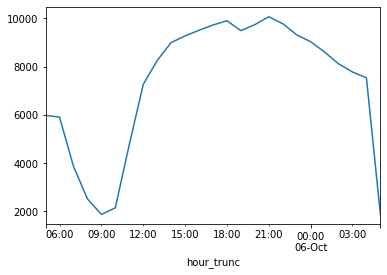

In [47]:
hourly_dropoffs.plot()

In [48]:
hourly_reset = merged_df[merged_df['Stop_Passengers'] == 0].groupby('hour_trunc')['Vehicle_ID'].count()

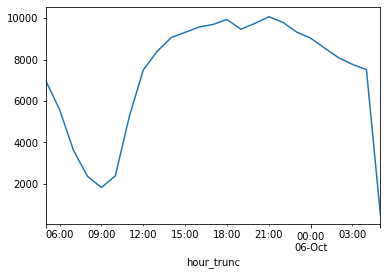

In [49]:
hourly_reset.plot()

In [ ]:
# interesting plots for count of records filtered by the different types of 'stops'
# turns out the timestamp is over the weekend, so the expected timeline doesn't exist that would be seen during the week

In [64]:
# looking for other biases
merged_df[merged_df['Latitude'].isna()]['hour_trunc'].value_counts()

2013-10-05 05:00:00    931
2013-10-05 06:00:00    919
2013-10-05 07:00:00    711
2013-10-05 21:00:00    688
2013-10-05 11:00:00    611
2013-10-05 12:00:00    606
2013-10-05 16:00:00    582
2013-10-05 22:00:00    581
2013-10-05 10:00:00    567
2013-10-05 08:00:00    559
2013-10-06 03:00:00    547
2013-10-05 20:00:00    545
2013-10-06 04:00:00    544
2013-10-05 18:00:00    527
2013-10-05 13:00:00    527
2013-10-05 15:00:00    525
2013-10-05 17:00:00    512
2013-10-05 23:00:00    508
2013-10-06 05:00:00    494
2013-10-06 01:00:00    481
2013-10-05 14:00:00    480
2013-10-05 09:00:00    480
2013-10-05 19:00:00    478
2013-10-06 02:00:00    474
2013-10-06 00:00:00    462
Name: hour_trunc, dtype: int64

In [65]:
# drop where there is no path
merged_df = merged_df[~merged_df['Latitude'].isna()]

In [166]:
# create a feature that can be parsed by carto easily. One that only shows passengers where 
# a stop happens to pick up or drop off a passenger
merged_df['parsed_pass_count'] = np.where(pd.concat([merged_df['Stop_Passengers'] == 0.0, 
                                                     merged_df['Stop_Passengers'].isnull()], axis=1).any(axis=1), 
                                          np.NaN, merged_df['Num_Passengers'])

In [140]:
# for the next part we will calculate distance traveled via lat long
# it's necessary to sort the data within vehicle and timestamp so measuring the next logical step
merged_df = merged_df.sort_values(by=['Vehicle_ID', 'Timestamp']).reset_index(drop=True)

In [118]:
# create lat long tuples
merged_df['latlon'] = merged_df[['Latitude', 'Longitude']].apply(tuple, axis=1)

In [144]:
# off set the tuples and reset at each vehicle_id
merged_df['latlon_previous'] = merged_df.groupby(['Vehicle_ID'])['latlon'].shift(1)

In [153]:
# create function to pass values into haversine. Since the first value of each will be 0 the function would break...
# adding exception important here. 
def hav_func(x):
    try:
        return haversine(x['latlon'], x['latlon_previous'],  unit=Unit.MILES)
    except TypeError:
        return 0

In [155]:
# apply function
merged_df['distance'] = merged_df.apply(lambda x: hav_func(x), axis=1)

In [157]:
#sum distance for each vehicle
dist_sum = merged_df.groupby('Vehicle_ID')['distance'].sum()

In [163]:
# map those values so it can be used by carto
merged_df['dist_sum_mapped'] = merged_df['Vehicle_ID'].map(dist_sum)

In [170]:
merged_df['parsed_pass_count'].value_counts()

4.0    175972
3.0    120615
2.0     41302
1.0     15874
0.0      5024
Name: parsed_pass_count, dtype: int64

In [172]:
# only keep necessary columns
final_df = merged_df[['Timestamp', 
                      'Vehicle_ID', 
                      'Latitude', 'Longitude', 
                      'Num_Passengers','parsed_pass_count', 'dist_sum_mapped']]

In [186]:
# take 5% sample so viz is readable
final_df = final_df[final_df['Vehicle_ID'].isin(dist_sum.sample(frac=.10).index)]

In [188]:
# export
final_df.to_csv('carto_rideshare_v2.csv', index=False)